In [99]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sounddevice as sd

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
#import mdct
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3
import scipy.signal as sig
import scipy.linalg as linalg
import IPython.display as ipd
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Useful functions

In [100]:
def load_music(file):
    return wave.open(file, 'rb')

def play_music(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_music(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [101]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [102]:
wavefile = load_music('clocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [103]:
play = False
if play :
    play_music('clocheB.WAV')

In [130]:
T, data, nframes, nchannels, sampling_frequency = read_values('clocheB.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())
xb = x.copy()
xb = xb[0]

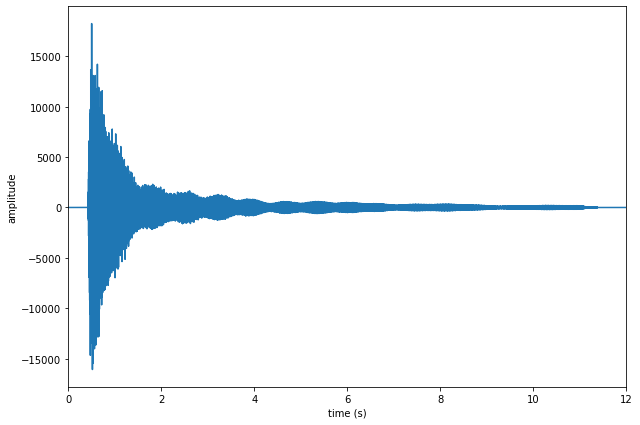

In [131]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

## 3

In [106]:
N = 63
delta0 = 0
delta1 = -0.05
f0 = 1/4
f1 = f0 + 1/N
a0 = 1
a1 = 10
phi = np.random.uniform(-np.pi, np.pi, 2)

x = Synthesis(N,np.array([delta0, delta1]), np.array([f0, f1]), np.array([a0, a1]), phi)

## 3.1
The peaks aren't exactly at the frequencies used, but are somewhat close. After applying the zero-padding it is clear that the resolution increased considerably, when before you could see something like a first peak, after padding it becomes very clear.

In [107]:
f, per = sig.periodogram(x, return_onesided=False)
f2, per2 = sig.periodogram(x, return_onesided=False, nfft=1024)

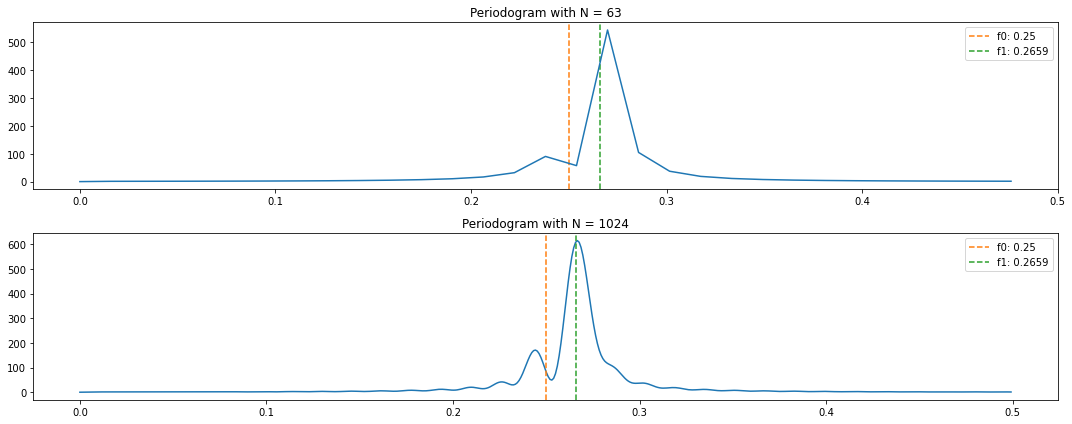

In [108]:
plt.subplots(2,1, figsize=(15,6))
plt.subplot(211)
plt.title('Periodogram with N = 63')
plt.axvline(f0, color='C1', ls='--', label=f'f0: {f0}')
plt.axvline(f1, color='C2', ls='--', label=f'f1: {f1:.4f}')
plt.plot(f[:31], per[:31])
plt.legend()
plt.subplot(212)
plt.title('Periodogram with N = 1024')
plt.plot(f2[:512], per2[:512])
plt.axvline(f0, color='C1', ls='--', label=f'f0: {f0}')
plt.axvline(f1, color='C2', ls='--', label=f'f1: {f1:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

## 3.2

In [109]:
def empirical_cov_matrix(x, n):
    l = len(x) - n + 1
    X = linalg.hankel(x[:n], x[n-1:])
    return X@X.conj().T/l

def subspace_estimation(Rxx, K, noise=False):
    u, _, _ = linalg.svd(Rxx)
    if noise == False:
        return u[:, :K]
    else:
        return u[:, K:]

## 3.2.1
### 3.

In [110]:
def W_up_down(W):
    return W[1:], W[:-1]

def ESPRIT (x, n, K):
    Rxx = empirical_cov_matrix(x, n)
    W = subspace_estimation(Rxx, K)
    Wup, Wdown = W_up_down(W)
    phi = linalg.pinv(Wdown)@Wup
    eigenval = linalg.eig(phi)[0]
    freq = np.angle(eigenval)/(2*np.pi)
    delta = np.log(abs(eigenval))
    return freq, delta

In [111]:
est_freq, est_delta = ESPRIT(x, 32, 2)

In [112]:
print(f'The frequencies are {f0} and {f1:.5f}')
print(f'The estimated frequencies are {est_freq[1]} and {est_freq[0]:.5f}\n')
print(f'The damping factors are {delta0} and {delta1}')
print(f'The estimated damping factors are {est_delta[1]:.5f} and {est_delta[0]:.5f}')

The frequencies are 0.25 and 0.26587
The estimated frequencies are 0.24999999999999997 and 0.26587

The damping factors are 0 and -0.05
The estimated damping factors are -0.00000 and -0.05000


### 4.

In [113]:
def vandermonde(freq, delta, K, N):
    t = np.arange(N).reshape((N, 1))
    aux = (delta + 1j*2*np.pi*freq).reshape(1, K)
    return np.exp(t@aux)

def leastsquares(x, delta, f, K):
    V = vandermonde(f, delta, K, len(x))
    alpha = linalg.pinv(V)@x
    return np.abs(alpha), np.angle(alpha)

In [114]:
est_amp, est_phase = leastsquares(x, est_delta, est_freq, 2)

In [115]:
print(f'The amplitudes are {a0} and {a1}')
print(f'The estimated amplitudes are {est_amp[1]:.3f} and {est_amp[0]:.3f}\n')
print(f'The phases are {phi[0]:.5f} and {phi[1]:.5f}')
print(f'The estimated phaes are {est_phase[1]:.5f} and {est_phase[0]:.5f}')

The amplitudes are 1 and 10
The estimated amplitudes are 1.000 and 10.000

The phases are 0.56549 and 1.72227
The estimated phaes are 0.56549 and 1.72227


### 5.
The ESPRIT and Least Squares functions were applied and were able to perfectly estimate everything.

### 3.2.2
The MUSIC algorithm was successful, at frequency of around 0.25 you can see two peaks, one at delta equal to zero and another at delta equals to -0.5. The one at zero has much higher amplitude, as expected.

When plotted with a log the peaks become far less visible. So despite deliberate instructions to do it as so, I refrained in order to obtain a more informative graph.

In [120]:
def MUSIC(x, n, K, definition=101):
    Rxx = empirical_cov_matrix(x, n)
    W = subspace_estimation(Rxx, K, noise=True)
    W = W.conj().T
    
    freq = np.linspace(0, 1, definition, endpoint=True)
    delta = np.linspace(-0.1, 0.1, definition, endpoint=True)
    freq, delta = np.meshgrid(freq, delta)
    P = np.zeros((definition, definition))
    t = np.arange(n)
    
    for i in range(definition):
        for j in range(definition):
            vn = np.exp(t*(delta[i][j] + 2j*np.pi*freq[i][j]))
            P[i][j] = 1/(linalg.norm(W@vn))**2      
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,5))
    surf = ax.plot_surface(freq, delta, P, cmap=cm.coolwarm)
    ax.zaxis.set_major_locator(LinearLocator(5))
    ax.zaxis.set_major_formatter('{x:.02f}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Damping factor')

    plt.tight_layout()
    plt.show()
    return P

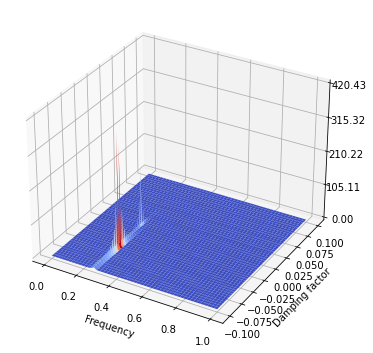

In [121]:
p = MUSIC(x, 32, 2, definition=500)

## 4
### 4.1

In [122]:
freqb, perb = sig.periodogram(xb)
pitch = freqb[np.argmax(perb)]
pitch

0.05683510943050304

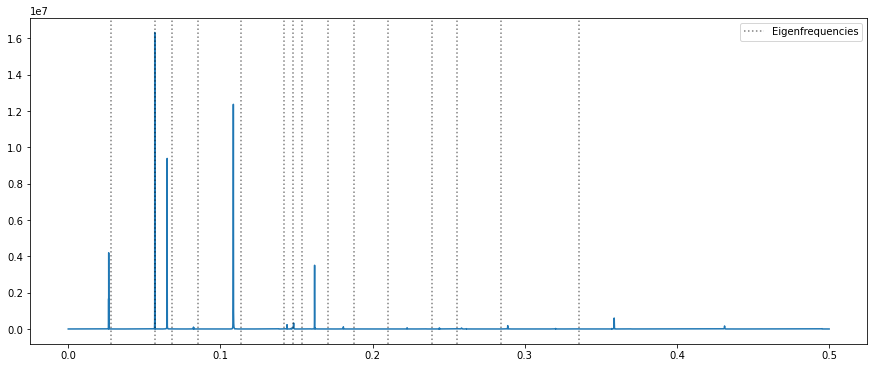

In [123]:
plt.figure(figsize=(15,6))
plt.plot(freqb, perb.reshape(-1))
plt.axvline(pitch, color='Black', ls=':', alpha=0.5, label='Eigenfrequencies')
plt.axvline(pitch*0.5, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*1.2, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*1.5, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*2, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*2.5, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*2.6, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*2.7, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*3, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*3.3, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*3.7, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*4.2, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*4.5, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*5, color='Black', ls=':', alpha=0.5)
plt.axvline(pitch*5.9, color='Black', ls=':', alpha=0.5)
plt.legend()
plt.show()

### 4.2

The replication worked and the sound resembles that of a bell, so the functions were successful despite not replicating exactly the same sound. This happened because the segment used was around of length equivalent to 1.5% of the synthesized signal. One could obtain the information from a larger segment, but because the least squares algorithm isn't very computationally efficient, this becomes a demanding task. 

In [150]:
freqb, deltab = ESPRIT(xb[10000:11535], n=512, K=54)

In [151]:
ampb, phaseb = leastsquares(xb[10000:11535], -abs(deltab), freqb, K=54)

In [152]:
bsin = Synthesis(len(xb), -abs(deltab), freqb, ampb, phaseb)

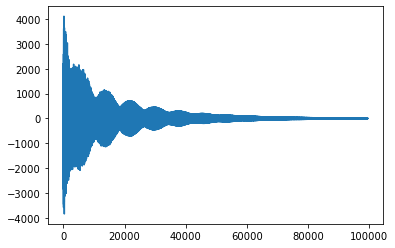

In [153]:
plt.plot(np.real(bsin))
plt.show()

Synthesized signal

In [149]:
ipd.Audio(np.real(bsin), rate=8000)

Actual bell

In [144]:
ipd.Audio(xb, rate=sampling_frequency)